In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import numpy as np
import pandas as pd
import scipy.optimize

from datetime import datetime
import pytz
central_time = pytz.timezone('US/Central')

import trfp
import gm2

matplotlib.rc('xtick', labelsize=10)     
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('axes', titlesize=10)
matplotlib.rc('axes', labelsize=10)
plt.rcParams["font.family"] = "serif"

Welcome to JupyROOT 6.12/04


In [2]:
tr3956 = trfp.TrolleyRun(3956)
corrected_df = trfp.remove_trolley_effect(tr3956)

_, fp_time, fp_freq = tr3956.fp_run.getBasics()
fp169_raw_df = pd.DataFrame(fp_freq[1:,169], index=fp_time[1:,169]/1.0e9, columns=['fp169'])

corrected_df.to_hdf('run3956.h5', key='corrected_df')
fp169_raw_df.to_hdf('run3956.h5', key='fp169_raw_df')
tr3956.interp_data.to_hdf('run3956.h5', key='tr3956_interp_df')
tr3956.moment_df.to_hdf('run3956.h5', key='tr3956_moment_df')

# corrected_df = pd.read_hdf('run3956.h5', key='corrected_df')
# fp169_raw_df = pd.read_hdf('run3956.h5', key='fp169_raw_df')
# tr3956_interp_df = pd.read_hdf('run3956.h5', key='tr3956_interp_df')
# tr3956_moment_df = pd.read_hdf('run3956.h5', key='tr3956_moment_df')

Reading event 8780/8781 99.99%  
loop done: 100%                                    
Reading event 2630/2634 99.85%  
loop done: 100%                                    
Finished calculating all moments for 4385 events.                                                     
Finished removing trolley images from 4385 events.             
Reading event 2630/2634 99.85%    
loop done: 100%                                    


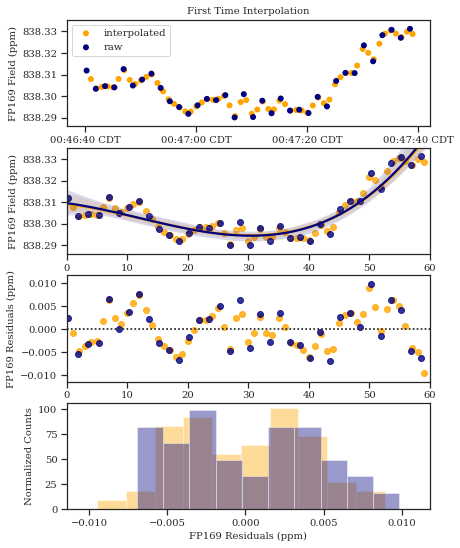

In [6]:
# Generates interesting plots
# Especially regressions, residuals, and histograms

data = fp169_raw_df['fp169']/61.79
t_start = 1524376000
t_stop = 1524376060
y_min = np.min(data.loc[(data.index > t_start) & (data.index < t_stop)])
y_max = np.max(data.loc[(data.index > t_start) & (data.index < t_stop)])
y_range = y_max - y_min
y_min = y_min - 0.1*y_range
y_max = y_max + 0.1*y_range

fig, axs = plt.subplots(4,1)

raw_color = 'navy'
int_color = 'orange'

raw_data = fp169_raw_df.loc[(fp169_raw_df.index > t_start) & (fp169_raw_df.index < t_stop)]/61.79
interp_data = tr3956.interp_data.loc[(tr3956.interp_data.index > t_start) & (tr3956.interp_data.index < t_stop)]/61.79

sns.scatterplot(x=interp_data.index.values, y=interp_data['fp169'],
                edgecolor='none', ax=axs[0], color=int_color, label='interpolated')
sns.scatterplot(x=raw_data.index.values, y=raw_data['fp169'],
                edgecolor='none', ax=axs[0], color=raw_color, label='raw')
axs[0].set_ylim(y_min,y_max)
xticks = axs[0].get_xticks()
xticks = xticks[1:len(xticks)-1:2]
axs[0].set_xticks(xticks)
_ = axs[0].set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%H:%M:%S %Z') 
                        for tm in xticks], rotation=0)
axs[0].legend(loc=2, prop={'size': 10})
axs[0].set_ylabel('FP169 Field (ppm)')

sns.regplot(x=interp_data.index.values-t_start, y=interp_data['fp169'], ax=axs[1], order=3, color=int_color)
sns.regplot(x=raw_data.index.values-t_start, y=raw_data['fp169'], ax=axs[1], order=3, color=raw_color)
axs[1].set_xlim(0, t_stop-t_start)
axs[1].set_ylim(y_min,y_max)
axs[1].set_ylabel('FP169 Field (ppm)')

x_fit1 = raw_data.index.values-t_start
y_fit1 = raw_data['fp169']
p_out1 = np.polyfit(x_fit1, y_fit1, 3)
y_out1 = np.polyval(p_out1, x_fit1)
resids1 = y_fit1-y_out1
resids1_max = np.max(resids1)
resids1_min = np.min(resids1)

x_fit2 = interp_data.index.values-t_start
y_fit2 = interp_data['fp169']
p_out2 = np.polyfit(x_fit2, y_fit2, 3)
y_out2 = np.polyval(p_out2, x_fit2)
resids2 = y_fit2-y_out2
resids2_max = np.max(resids2)
resids2_min = np.min(resids2)

resids_max = np.max([resids1_max,resids2_max])
resids_min = np.min([resids1_min,resids2_min])
resids_range = resids_max-resids_min
resids_max = resids_max + 0.1*resids_range
resids_min = resids_min - 0.1*resids_range

sns.residplot(x=interp_data.index.values-t_start, y=interp_data['fp169'], ax=axs[2], order=3, color=int_color)
sns.distplot(resids2,bins=10, norm_hist=True, kde=False, color=int_color, ax=axs[3])
sns.residplot(x=raw_data.index.values-t_start, y=raw_data['fp169'], ax=axs[2], order=3, color=raw_color)
sns.distplot(resids1,bins=10, norm_hist=True, kde=False, color=raw_color, ax=axs[3])

axs[2].set_xlim(0, t_stop-t_start)
axs[2].set_ylim(resids_min,resids_max)
axs[2].set_ylabel('FP169 Residuals (ppm)')

axs[3].set_xlim(resids_min, resids_max)
axs[3].set_ylabel('Normalized Counts')
axs[3].set_xlabel('FP169 Residuals (ppm)')

axs[0].set_title('First Time Interpolation')
fig.set_size_inches(6.5,9)

fig.savefig('test_out.png',dpi=600)